# Table of Contents
 <p>

In [2]:
import pandas as pd
import numpy as np
import scipy as scipy
import sklearn.decomposition
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import os
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})


%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [3]:
strains =['PS4187', 'PS4087', 'PS4176']

strain_dict = {}
for i, g in enumerate(strains):
    strain_dict[g] = i

In [4]:
q = 0.1

In [5]:
genmap = pd.read_csv('../sleuth/rna_seq_info.txt', sep='\t', comment='#')

In [6]:
genmap = pd.read_csv('../sleuth/rna_seq_info.txt', sep='\t', comment='#')
frames = []

for root, dirs, files in os.walk("../sleuth/sleuth_strains"):
    for file in files:
        if file == 'lrt.csv':
            continue
            
        strain =  file[:-4].replace('_', '-')
        if strain[2:] not in strains:
            continue

        df = pd.read_csv(root + '/' + file, sep=',')
        df.sort_values('target_id', inplace=True)
        df['strain'] = strain.replace('b-', '')
        df['genotype'] = genmap[genmap.strain == file[:-4]].genotype.unique()[0].replace('b_', '').replace('_', '-')
        df['order'] = strain_dict[df.strain.unique()[0]]
        frames += [df]
    
tidy = pd.concat(frames)
tidy.dropna(subset=['ens_gene', 'b', 'qval'], inplace=True)
tidy['absb'] = tidy.b.abs()
tidy.sort_values(['order', 'target_id'], ascending=True, inplace=True)
tidy.head()

tidy.to_csv('../input/quantifications.csv', index=False)

In [7]:
total_genes_id = tidy.target_id.unique().shape[0]
print("Total isoforms identified in all genotypes: {0}".format(total_genes_id))
print("Total genes identified in all genotypes: {0}".format(len(tidy.ens_gene.unique())))

Total isoforms identified in all genotypes: 21954
Total genes identified in all genotypes: 15121


In [7]:
print('Genotype, Strain: DEG')
for x in tidy.strain.unique():
    # select the DE isoforms in the current genotype:
    sel = (tidy.qval < q) & (tidy.strain == x)
    # extract the number of unique genes:
    s = tidy[sel].ens_gene.unique().shape[0]
    genotype = tidy[tidy.strain == x].genotype.unique()[0]
    print(
          """{0}, {1}: {2}""".format(genotype, x, s))

Genotype, Strain: DEG
dpy22.bx93, PS4187: 481
dpy22-sy622, PS4087: 2863
dpy22-transhet-sy622-bx93, PS4176: 2214


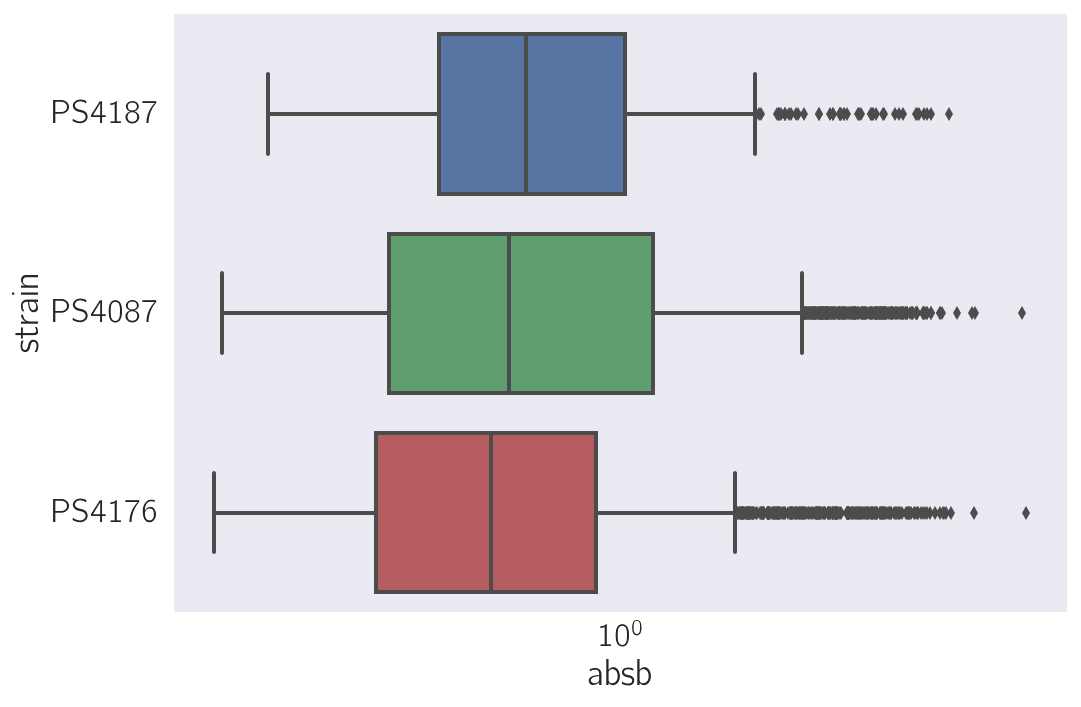

In [9]:
sns.boxplot(x='absb', y='strain', data=tidy[tidy.qval < q])
plt.xscale('log')

In [10]:
sig = (tidy.qval < q)
print('pair, shared GENES, percent shared (isoforms)')
for i, g1 in enumerate(tidy.strain.unique()):
    genes1 = tidy[sig & (tidy.strain == g1)]
    for j, g2 in enumerate(tidy.strain.unique()[i+1:]):
        genes2 = tidy[sig & (tidy.strain == g2)]
        
        # find the overlap between the two:
        OR = ((tidy.strain == g1) | (tidy.strain == g2)) 
        size1 = tidy[(tidy.strain == g1) & (tidy.qval < q)].shape[0]
        size2 = tidy[(tidy.strain == g1) & (tidy.qval < q)].shape[0]
        
        n_iso = genes2[genes2.target_id.isin(genes1.target_id)].shape[0]
        ntot = len(tidy[sig & OR].target_id.unique())
        if n_iso/np.min([size1, size2]) > .0:
            print(
                "{0}---{1}, {2}, {3:.2g}%, {4:.2g}%".format(g1, g2, n_iso, 100*n_iso/ntot, 100*n_iso/np.min([size1, size2]))
                 )

pair, shared GENES, percent shared (isoforms)
PS4187---PS4087, 350, 11%, 72%
PS4187---PS4176, 301, 12%, 62%
PS4087---PS4176, 985, 23%, 33%


In [11]:
bx93 = pd.read_csv('../sleuth/sleuth_GLM/bx93.csv')
sy622 = pd.read_csv('../sleuth/sleuth_GLM/sy622.csv')
het = pd.read_csv('../sleuth/sleuth_GLM/interaction.csv')

bx93['genotype'] = 'bx93'
sy622['genotype'] = 'sy622'
het['genotype'] = 'het'
glm = pd.concat([bx93, sy622, het])

In [12]:
for name, group in glm.groupby('genotype'):
    print(name, group[group.qval < q].shape[0])

bx93 1631
het 2931
sy622 5137


In [13]:
cond1 = ((glm.genotype == 'bx93') & (glm.qval < q))
cond2 = ((glm.genotype == 'sy622') & (glm.qval < q)) & ((glm.genotype == 'het') & (glm.qval < q))
glm[cond2].shape

(0, 15)

In [14]:
glm[glm.qval < q].shape[0]

9699

In [15]:
import statsmodels.api as sm

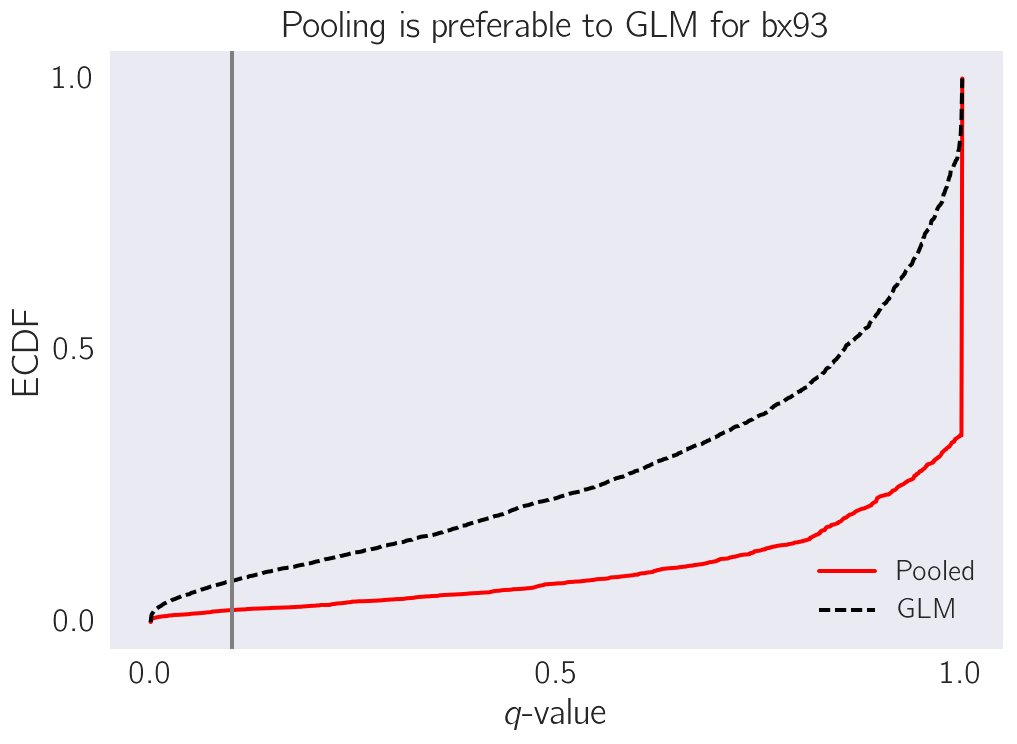

In [16]:
def plot_ecdf(gene, strain):
    """
    A function to plot ECDFs of qvalues for two models.
    gene -- the genotype to be plotted
    strain -- the strain to be plotted
    
    Output:
    a matplotlibplot
    """
    ecdf_bx93_glm = sm.distributions.ECDF(glm[(glm.genotype == gene)].qval.dropna())
    ecdf_bx93 = sm.distributions.ECDF(tidy[(tidy.strain == strain)].qval)

    x = np.linspace(0, 1, 1000)
    plt.plot(x, ecdf_bx93(x), 'r', label='Pooled')
    plt.plot(x, ecdf_bx93_glm(x), 'k--', label='GLM')
    # plt.axhline(0.5, ls='-.', lw=1)
    plt.axvline(0.1, ls='-', color='gray', lw=2)
    plt.legend()
    plt.xlabel(r'$q$-value')
    plt.ylabel('ECDF')

    plt.xticks([0, 0.5, 1])
    plt.yticks([0, 0.5, 1])

plot_ecdf('bx93', 'PS4187')
plt.title("Pooling is preferable to GLM for bx93")

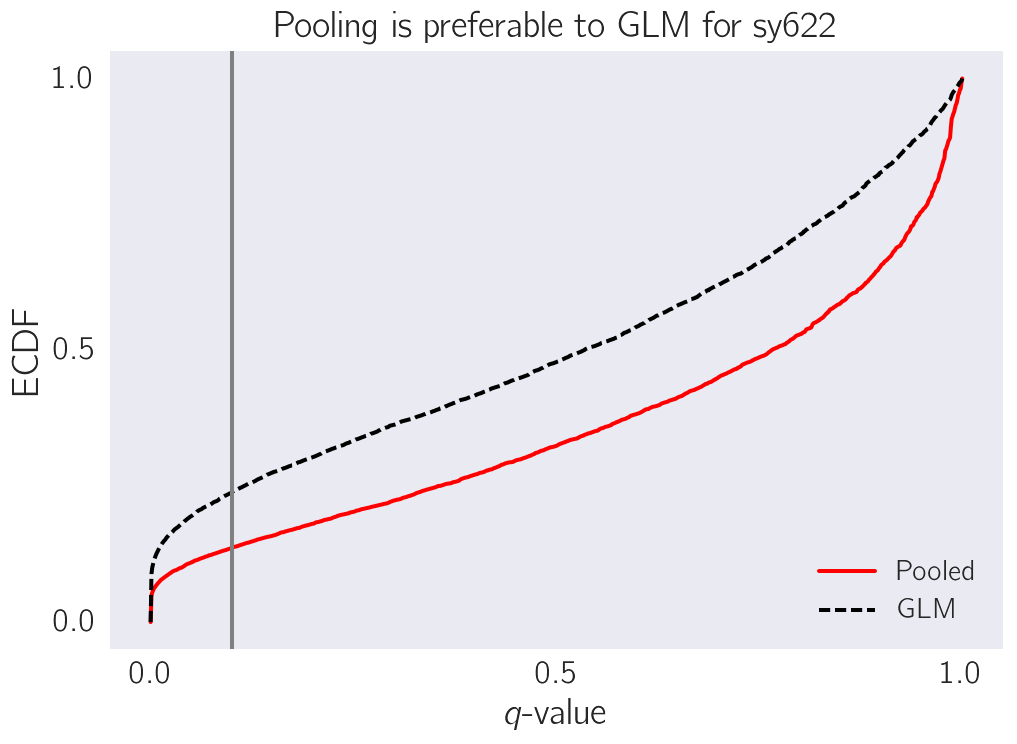

In [17]:
plot_ecdf('sy622', 'PS4087')
plt.title("Pooling is preferable to GLM for sy622")

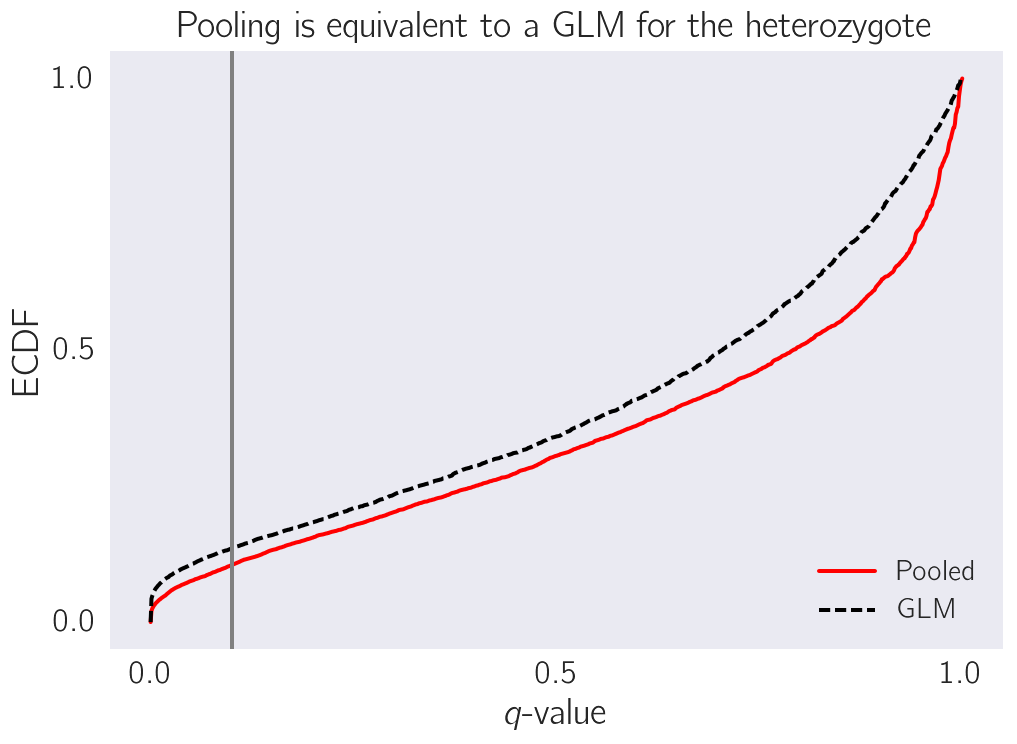

In [18]:
plot_ecdf('het', 'PS4176')
plt.title("Pooling is equivalent to a GLM for the heterozygote")

In [19]:
glm.sort_values('qval').dropna().shape

(64605, 15)